In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import seaborn as sns
import missingno as msn

In [2]:
df = pd.read_csv('data.csv')

In [3]:
df.drop(['id','Unnamed: 32'],axis=1,inplace=True)

In [4]:
dic = {'B':0,'M':1}
df['diagnosis'] = df['diagnosis'].map(dic)

<AxesSubplot:>

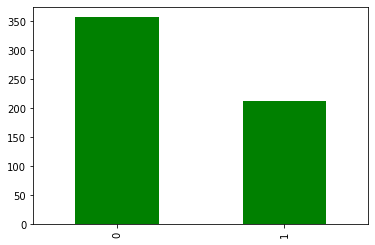

In [5]:
df['diagnosis'].value_counts().plot(kind='bar',color='green')

In [6]:
# it is better if we use an oversample for increse the malignant feature

In [7]:
y = df['diagnosis']
X = df.drop('diagnosis',axis=1)
X = df[['concave points_mean','area_mean','radius_mean','perimeter_mean','concavity_mean']]
# remember feature order whn you deploy :)

In [8]:
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

os=RandomOverSampler(0.9)
X_ns,y_ns=os.fit_sample(X,y)
print("The number of classes before fit {}".format(Counter(y)))
print("The number of classes after fit {}".format(Counter(y_ns)))

The number of classes before fit Counter({0: 357, 1: 212})
The number of classes after fit Counter({0: 357, 1: 321})


C:\Users\Acer\anaconda3\lib\site-packages\imblearn\utils\_validation.py:638: FutureWarning: Pass sampling_strategy=0.9 as keyword args. From version 0.9 passing these as positional arguments will result in an error
  FutureWarning)


In [9]:
X = X_ns
y = y_ns

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=40)

In [11]:
from xgboost import XGBClassifier

In [12]:
xgb = XGBClassifier()

In [13]:
xgb.get_params()

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 3,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 100,
 'n_jobs': 1,
 'nthread': None,
 'objective': 'binary:logistic',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': None,
 'silent': None,
 'subsample': 1,
 'verbosity': 1}

In [14]:
grid = {
    
    'max_depth':range(3,100),
 'min_child_weight':range(1,20),
 'gamma':[i/10.0 for i in range(0,5)],
    'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)],
    'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}

In [15]:
from sklearn.model_selection import StratifiedKFold
cv = StratifiedKFold(n_splits=10, shuffle=True)

In [16]:
from sklearn.model_selection import RandomizedSearchCV
xgb_random = RandomizedSearchCV(estimator=xgb, param_distributions=grid, n_jobs=-1,n_iter = 100, cv=cv, scoring='accuracy',error_score=0,return_train_score=True,verbose=2)

In [17]:
xgb_random.fit(X_train,y_train)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=True),
                   error_score=0, estimator=XGBClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.7, 0.8,
                                                             0.9],
                                        'gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
                                        'max_depth': range(3, 100),
                                        'min_child_weight': range(1, 20),
                                        'reg_alpha': [1e-05, 0.01, 0.1, 1, 100],
                                        'subsample': [0.6, 0.7, 0.8, 0.9]},
                   return_train_score=True, scoring='accuracy', verbose=2)

In [18]:
## Evaluate

In [19]:
best_model = xgb_random.best_estimator_

In [20]:
best_model

XGBClassifier(colsample_bytree=0.7, gamma=0.2, max_depth=11, min_child_weight=8,
              reg_alpha=0.1, subsample=0.9)

In [21]:
xgb_random.best_params_

{'subsample': 0.9,
 'reg_alpha': 0.1,
 'min_child_weight': 8,
 'max_depth': 11,
 'gamma': 0.2,
 'colsample_bytree': 0.7}

In [22]:
xgb_random.best_score_

0.9324911347517733

In [23]:
y_pred = best_model.predict(X_test)

In [24]:
err  =(y_pred- y_test)

<AxesSubplot:>

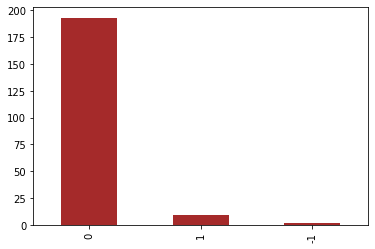

In [25]:
err.value_counts().plot(kind='bar',color='brown')

In [26]:
from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(y_test,y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

MAE: 0.05392156862745098
MSE: 0.05392156862745098
RMSE: 0.232210182006412


In [27]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[99  9]
 [ 2 94]]
              precision    recall  f1-score   support

           0       0.98      0.92      0.95       108
           1       0.91      0.98      0.94        96

    accuracy                           0.95       204
   macro avg       0.95      0.95      0.95       204
weighted avg       0.95      0.95      0.95       204



In [28]:
import pickle
# open a file, where you ant to store the data
file = open('xgboost_cancer.pkl', 'wb')
# dump information to that file
pickle.dump(best_model, file)
file.close()